<a href="https://colab.research.google.com/github/gabilodeau/INF6804/blob/master/Object_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## INF6804 Vision par ordinateur

**Polytechnique Montréal**

**Auteur :** Khalil Sabri

**Description :** Ce Jupyter notebook présente un exemple d'utilisation de modèles de détection d'objets (YOLOX, Faster R-CNN, CenterNet, Mask R-CNN). Il est divisé en cinq parties :

1. **Installation de MMDetection**
2. **Téléchargement du dataset :** Utilisation du dataset réduit coco2017mini pour  tester les modèles.
3. **Configuration des modèles et téléchargement des poids :** Les chemins de configuration et les liens vers les poids des modèles sont définis. Vous pouvez facilement tester d'autres modèles en ajoutant leurs liens et fichiers de configuration de la même manière.
4. **Chargement des modèles :** Les modèles sont initialisés sur l'appareil disponible (GPU ou CPU).
5. **Inférence et visualisation :** Inférence sur des images aléatoires du dataset et visualisation des résultats avec boîtes englobantes et classes.

## 1. Installation de MMDetection

Assurez-vous de sélectionner Cuda ! Le Colab pourrait vous demander, après l'installation de Pytorch, de relancer le notebook. Acceptez et relancez les premières cellules, mais ne réinstallez pas Pytorch car cela est déjà fait. Continuez à exécuter le reste du notebook.

Make sure you select Cuda ! The Colab might ask you after installing Pytorch to rerun the colab, accept and re-run the first cells, but do not re-run pytorch installation as it`s already done. Continue running the rest.


In [1]:
!pip install torch==2.0.1 torchvision==0.15.2 torchaudio==2.0.2 torchdata==0.6.1 torchtext==0.15.2

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 619.9/619.9 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 48.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.4/4.4 MB 71.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.6/4.6 MB 55.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 44.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.1/317.1 MB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 28.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.0/21.0 MB 87.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 849.3/849.3 kB 47.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 557.1/557.1 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 168.4/168.4 MB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.6/54.6 MB 11.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102.6/102.

In [1]:
!pip install openmim
!mim install -q "mmengine>=0.6.0"
!mim install -q "mmcv>=2.0.0rc4,<2.1.0"
!mim install -q "mmdet>=3.0.0rc6,<3.1.0"

!git clone https://github.com/open-mmlab/mmyolo.git
!git clone https://github.com/open-mmlab/mmdetection.git

fatal: destination path 'mmyolo' already exists and is not an empty directory.
fatal: destination path 'mmdetection' already exists and is not an empty directory.


In [2]:
!pip install -q supervision==0.13.0 pycocotools

In [3]:
import cv2
import os
import json
import torch
import random
import numpy as np
import supervision as sv


from mmdet.apis import init_detector, inference_detector
import zipfile
from mmdet.datasets.coco import CocoDataset


HOME = os.getcwd()
print("HOME:", HOME)

HOME: /content


## 2. Téléchargement du dataset: coco2017mini

In [4]:
# Download the COCO 2017 Mini dataset
!wget -q http://images.cocodataset.org/zips/val2017.zip -O val2017.zip

with zipfile.ZipFile('val2017.zip', 'r') as zip_ref:
    zip_ref.extractall('coco2017mini')

# List the images
image_dir = './coco2017mini/val2017'
image_files = os.listdir(image_dir)
print(f"Total images downloaded: {len(image_files)}")


Total images downloaded: 5000


## 3. Configuration des modèles et téléchargement des poids (Yolov8, Faster R-CNN, CenterNet, Mask R-CNN)

In [5]:
os.makedirs(f"{HOME}/configs", exist_ok=True)
os.makedirs(f"{HOME}/weights", exist_ok=True)

# Define models, their config paths, and weight URLs
models = {
    "YOLOX": {
        "config_path": f"{HOME}/mmdetection/configs/yolox/yolox_x_8xb8-300e_coco.py",
        "weights_url": "https://download.openmmlab.com/mmdetection/v2.0/yolox/yolox_x_8x8_300e_coco/yolox_x_8x8_300e_coco_20211126_140254-1ef88d67.pth"
    },
    "Faster R-CNN": {
        "config_path": f"{HOME}/mmdetection/configs/faster_rcnn/faster-rcnn_x101-64x4d_fpn_1x_coco.py",
        "weights_url": "https://download.openxlab.org.cn/models/mmdetection/FasterR-CNN/weight/faster-rcnn_x101-64x4d_fpn_2x_coco"
    },
    "CenterNet": {
        "config_path": f"{HOME}/mmdetection/configs/centernet/centernet-update_r50-caffe_fpn_ms-1x_coco.py",
        "weights_url": "https://download.openmmlab.com/mmdetection/v3.0/centernet/centernet-update_r50-caffe_fpn_ms-1x_coco/centernet-update_r50-caffe_fpn_ms-1x_coco_20230512_203845-8306baf2.pth"
    },
    "Mask R-CNN": {
        "config_path": f"{HOME}/mmdetection/configs/mask_rcnn/mask-rcnn_x101-64x4d_fpn_1x_coco.py",
        "weights_url": "https://download.openmmlab.com/mmdetection/v2.0/mask_rcnn/mask_rcnn_x101_64x4d_fpn_1x_coco/mask_rcnn_x101_64x4d_fpn_1x_coco_20200201-9352eb0d.pth"
    }
}

# Download each model's config and weights
for model_name, model_info in models.items():
    config_directory = os.path.dirname(model_info["config_path"])
    os.makedirs(config_directory, exist_ok=True)
    # config_url = model_info["config_path"].replace(HOME, "https://raw.githubusercontent.com/open-mmlab/mmdetection/master") + ".py"
    # !wget -P {config_directory} -q {config_url}
    !wget -P {HOME}/weights -q {model_info["weights_url"]}

# List the downloaded weights to verify
!ls -lh {HOME}/weights


total 1.3G
-rw-r--r-- 1 root root 133M May 15  2023 centernet-update_r50-caffe_fpn_ms-1x_coco_20230512_203845-8306baf2.pth
-rw-r--r-- 1 root root 382M Jun  2  2023 faster-rcnn_x101-64x4d_fpn_2x_coco
-rw-r--r-- 1 root root 392M Nov  2  2021 mask_rcnn_x101_64x4d_fpn_1x_coco_20200201-9352eb0d.pth
-rw-r--r-- 1 root root 379M Dec  7  2021 yolox_x_8x8_300e_coco_20211126_140254-1ef88d67.pth


## 4. Chargement des modèles

In [6]:
## Function to load each model
def load_model(model_name):
    config_path = models[model_name]["config_path"]
    weights_path = f"{HOME}/weights/{os.path.basename(models[model_name]['weights_url'])}"
    model = init_detector(config_path, weights_path, device=DEVICE)
    return model


In [7]:
# Define the device
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

# Load each model
yolov8_model = load_model("YOLOX")
faster_rcnn_model = load_model("Faster R-CNN")
centernet_model = load_model("CenterNet")
mask_rcnn_model = load_model("Mask R-CNN")

Loads checkpoint by local backend from path: /content/weights/yolox_x_8x8_300e_coco_20211126_140254-1ef88d67.pth
Loads checkpoint by local backend from path: /content/weights/faster-rcnn_x101-64x4d_fpn_2x_coco
Loads checkpoint by local backend from path: /content/weights/centernet-update_r50-caffe_fpn_ms-1x_coco_20230512_203845-8306baf2.pth
Loads checkpoint by local backend from path: /content/weights/mask_rcnn_x101_64x4d_fpn_1x_coco_20200201-9352eb0d.pth


## 5. Inférence et visualisation

In [8]:
# Function to perform inference and visualize results
def visualize_detections(model, image_path, confidence_threshold=0.3):
    image = cv2.imread(image_path)
    result = inference_detector(model, image)
    detections = sv.Detections.from_mmdetection(result)
    detections = detections[detections.confidence > confidence_threshold].with_nms()

    box_annotator = sv.BoxAnnotator()
    annotated_image = box_annotator.annotate(image.copy(), detections)
    sv.plot_image(image=annotated_image, size=(10, 10))


In [9]:
def visualize_detections(model, image_path, confidence_threshold=0.3):
    # Accessing COCO class labels from CocoDataset
    class_names = CocoDataset.METAINFO['classes']

    # Read the input image
    image = cv2.imread(image_path)

    # Run inference using the model
    result = inference_detector(model, image)

    # Get detections from the result
    detections = sv.Detections.from_mmdetection(result)

    # Filter detections based on confidence threshold
    detections = detections[detections.confidence > confidence_threshold].with_nms()

    # Create a list of class names corresponding to the detected class_ids
    detection_labels = [class_names[class_id] for class_id in detections.class_id]

    # Create a box annotator
    box_annotator = sv.BoxAnnotator()

    # Annotate the image with bounding boxes and class names
    annotated_image = box_annotator.annotate(image.copy(), detections, labels=detection_labels)

    # Display the annotated image
    sv.plot_image(image=annotated_image, size=(10, 10))


In [24]:
# Optionally set a seed for reproducible image selection
#random.seed(0)  # Comment this line to see results on different images and enjoy :)

# Select a random image
random_image = random.choice(image_files)
IMAGE_PATH = os.path.join(image_dir, random_image)

print(f"Selected image: {IMAGE_PATH}")


Selected image: ./coco2017mini/val2017/000000500663.jpg


### 5.1 Yolo

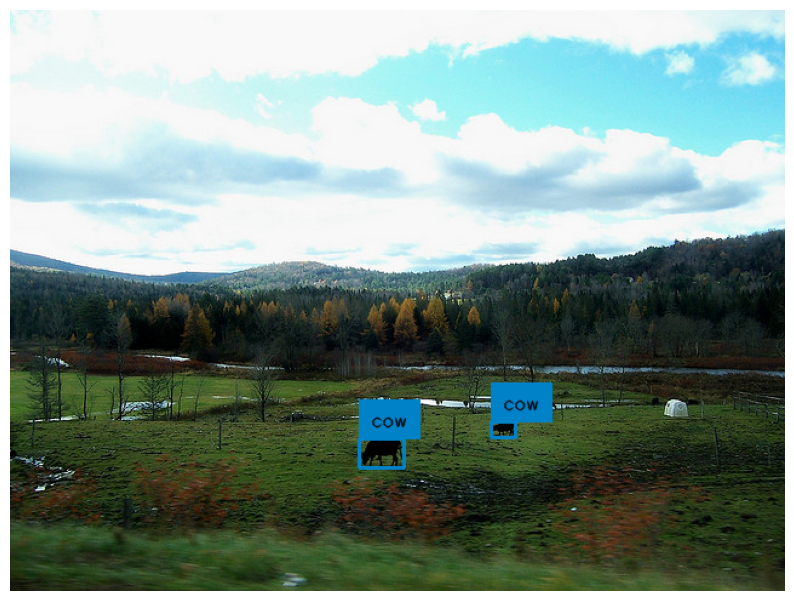

In [25]:
# Perform inference and visualize results using the YOLOv8 model
visualize_detections(yolov8_model, IMAGE_PATH)

### 5.2 Faster R-CNN


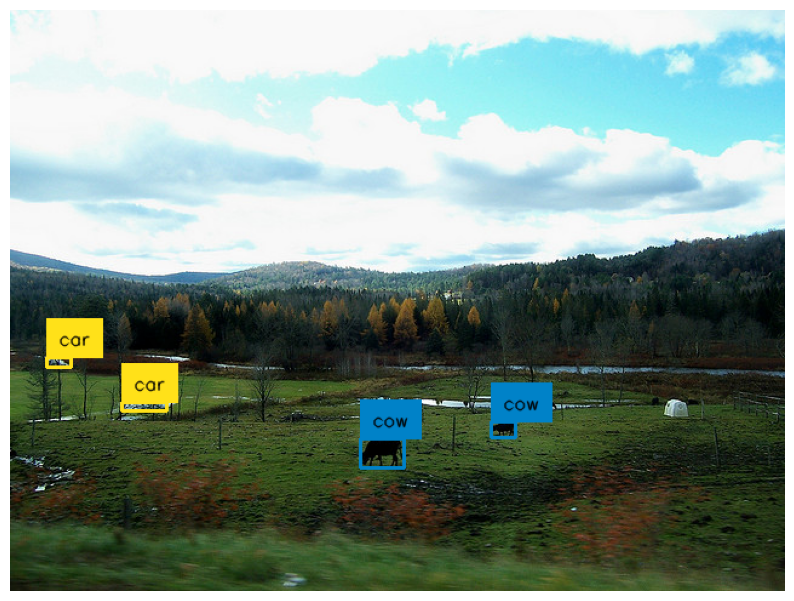

In [26]:
# Perform inference and visualize results using the Faster R-CNN model
visualize_detections(faster_rcnn_model, IMAGE_PATH)

### 5.3 CenterNet

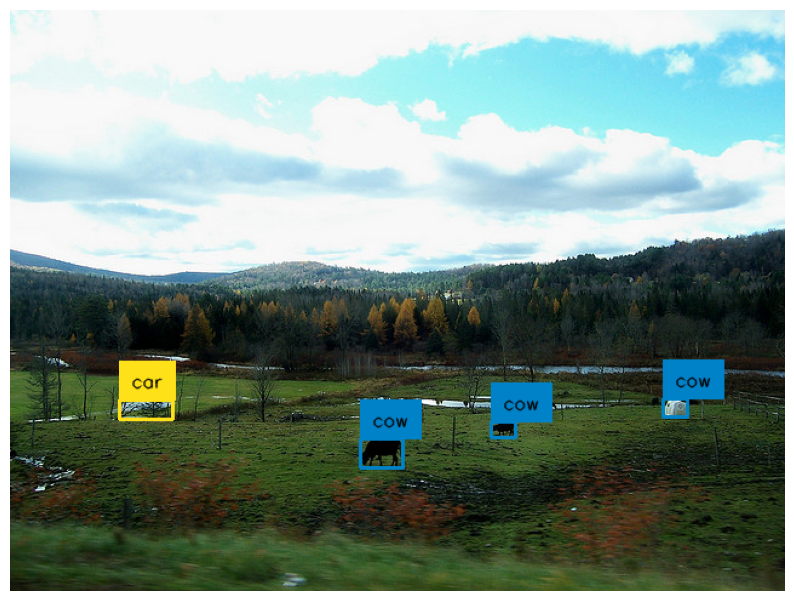

In [27]:
# Perform inference and visualize results using the CenterNet model
visualize_detections(centernet_model, IMAGE_PATH)

### 5.4 Mask R-CNN

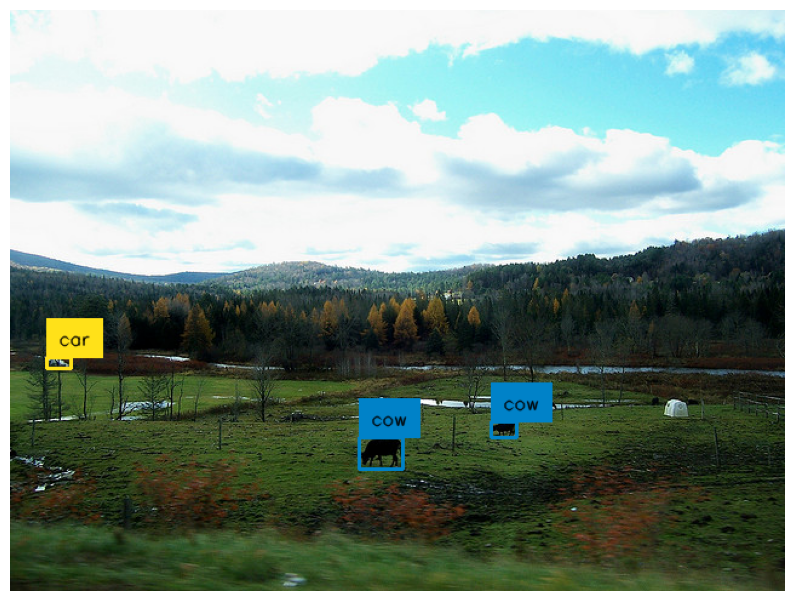

In [28]:
# Perform inference and visualize results using the Mask R-CNN model
visualize_detections(mask_rcnn_model, IMAGE_PATH)